In [1]:
from datetime import datetime
import numpy as np             #for numerical computations like log,exp,sqrt etc
import pandas as pd            #for reading & storing data, pre-processing
import matplotlib.pylab as plt #for visualization
#for making sure matplotlib plots are generated in Jupyter notebook itself
%matplotlib inline             
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.pylab import rcParams
import statsmodels.api as sm
import seaborn as sns
import pmdarima as pm
rcParams['figure.figsize'] = 10, 6

In [2]:
path = "AirPassengers.csv" #For Kaggle
dataset = pd.read_csv(path)
dataset

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


In [3]:
#Parse strings to datetime type
dataset['Month'] = pd.to_datetime(dataset['Month'],infer_datetime_format=True) #convert from string to datetime
indexedDataset = dataset.set_index(['Month'])
indexedDataset.rename(columns = {'#Passengers':'Passengers'}, inplace = True)

In [4]:
(dataset.Month[143] - dataset.Month[0]) /np.timedelta64(1, 'M')

142.98445553296781

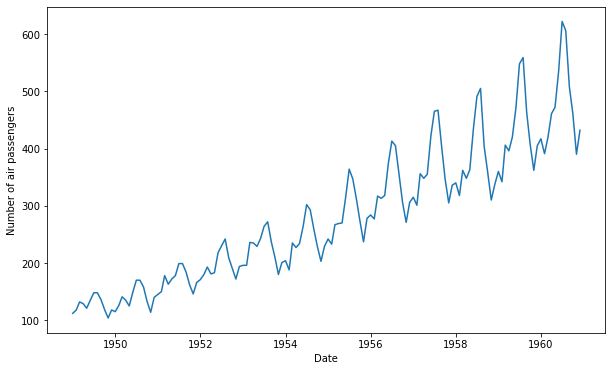

In [5]:
## plot graph
plt.xlabel('Date')
plt.ylabel('Number of air passengers')
plt.plot(indexedDataset)

            Passengers
Month                 
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
...                ...
1960-08-01  463.333333
1960-09-01  467.083333
1960-10-01  471.583333
1960-11-01  473.916667
1960-12-01  476.166667

[144 rows x 1 columns]             Passengers
Month                 
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
...                ...
1960-08-01   83.630500
1960-09-01   84.617276
1960-10-01   82.541954
1960-11-01   79.502382
1960-12-01   77.737125

[144 rows x 1 columns]


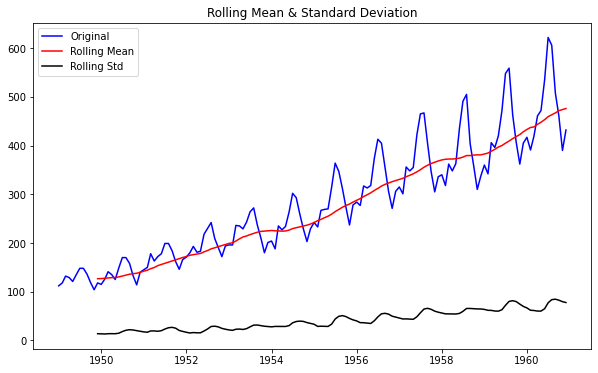

In [6]:
#Determine rolling statistics
rolmean = indexedDataset.rolling(window=12).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
rolstd = indexedDataset.rolling(window=12).std()
print(rolmean,rolstd)
#Plot rolling statistics
orig = plt.plot(indexedDataset, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [7]:
#Perform Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(indexedDataset['Passengers'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


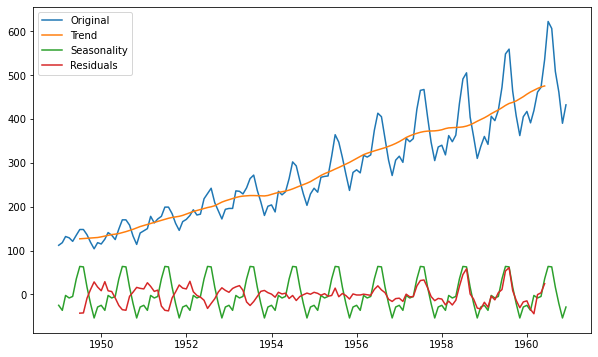

In [8]:
decomposition = seasonal_decompose(indexedDataset) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.plot(indexedDataset, label='Original')
plt.legend(loc='best')

plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.show()

In [9]:

# define helper plot function for visualization
def plots(data, lags=None):
    layout = (3, 1)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (1, 0))
    pacf = plt.subplot2grid(layout, (2, 0))
    
    raw.plot(data)
    sm.tsa.graphics.plot_acf(data, lags=lags, ax=acf, zero=False)
    sm.tsa.graphics.plot_pacf(data, lags=lags, ax=pacf, zero = False)
    sns.despine()

In [10]:
indexedDataset_logScale = np.log(indexedDataset)
dataset_dif = indexedDataset['Passengers'].diff()

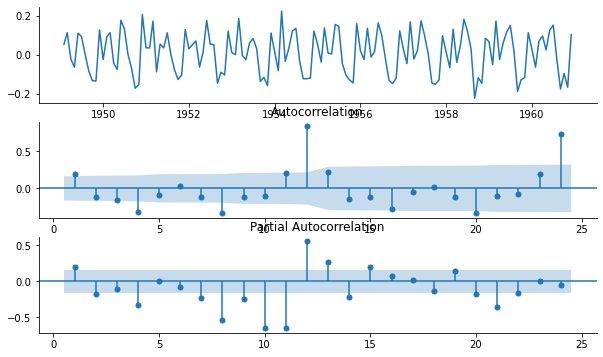

In [11]:
datasetLogDiffShifting = indexedDataset_logScale - indexedDataset_logScale.shift()
datasetLogDiffShifting.dropna(inplace=True)
plt.plot(datasetLogDiffShifting)
plots(datasetLogDiffShifting, lags = 24)
datasetLogDiffShifting_train = datasetLogDiffShifting[:-30]
datasetLogDiffShifting_test = datasetLogDiffShifting[-30:]

In [12]:
# fit SARIMA monthly based on helper plots
sar = sm.tsa.statespace.SARIMAX(datasetLogDiffShifting_train['Passengers'], 
                                order=(1,0,0), 
                                seasonal_order=(0,1,1,12), 
                                trend='c').fit()
sar.summary()

/home/eman/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/eman/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                           Passengers   No. Observations:                  113
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 12)   Log Likelihood                 186.768
Date:                              Mon, 24 May 2021   AIC                           -365.536
Time:                                      00:40:55   BIC                           -355.076
Sample:                                  02-01-1949   HQIC                          -361.301
                                       - 06-01-1958                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0004      0.002     -0.200      0.842      -0.004       0.004
ar.L1         -0.3008      0.079     -3.802      0.000      -0.456      -0.146
ma.S.L12      -0.5739      0.105     -5.450      0.000      -0.780      -0.368
sigma2         0.0014      0.000      7.345      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.65
Prob(Q):                              0.98   Prob(JB):                         0.72
Heteroskedasticity (H):               0.23   Skew:                             0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

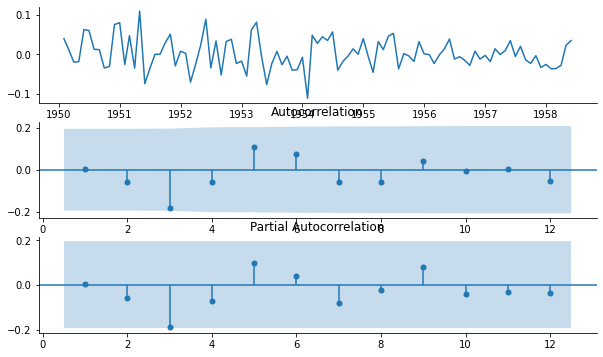

In [13]:
# plot resids
plots(sar.resid[sar.loglikelihood_burn:], lags=12);

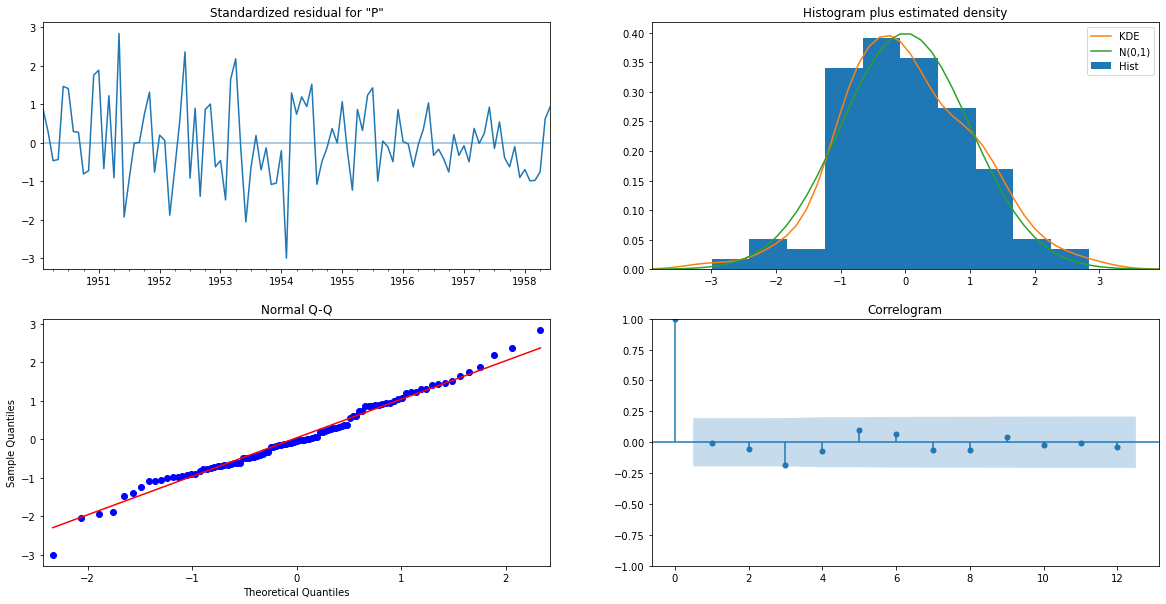

In [14]:
# plot residual diagnostics
sar.plot_diagnostics(lags=12,figsize = (20,10),);

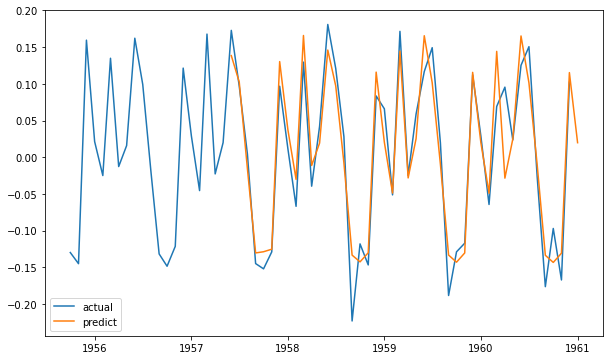

In [17]:
# plot predictions
pd.plotting.register_matplotlib_converters()
#use model.predict() start and end in relation to series
#datasetLogDiffShifting['forecast'] = sar.predict(start = 120, end= 143)  
#datasetLogDiffShifting[100:][['Passengers', 'forecast']].plot();
plt.plot(datasetLogDiffShifting.Passengers[80:], label = 'actual')
plt.legend()
plt.plot(sar.predict(start = 100, end= 143), label = 'predict')
plt.legend()
plt.show()

In [37]:
#Defining an error metric to see out of sample accuracy
def mape(actual , forecast):
    
    return abs(actual- forecast).sum() / abs(actual.sum())

In [38]:
sar_mape = mape(datasetLogDiffShifting_test.Passengers,sar.predict(start = 114, end= 143))
sar_mape

143.32969518335972

In [39]:
#[Durbin Watson](https://en.wikipedia.org/wiki/Durbin–Watson_statistic)
#    - Tests autocorrelation of residuals: we want between 1-3, 2 is ideal (no serial correlation)
durbin_watson = sm.stats.stattools.durbin_watson(
    sar.filter_results.standardized_forecasts_error[0, sar.loglikelihood_burn:])
durbin_watson

1.986377716735659

In [40]:
from dateutil.relativedelta import relativedelta
def future_preds_df(model,series,num_months):
    pred_first = series.index.max()+relativedelta(months=1)
    pred_last = series.index.max()+relativedelta(months=num_months)
    date_range_index = pd.date_range(pred_first,pred_last,freq = 'MS')
    vals = model.predict(n_periods = num_months)
    return pd.DataFrame(vals,index = date_range_index)

In [43]:

#from pyramid.arima import auto_arima
stepwise_model = pm.auto_arima(datasetLogDiffShifting_train['Passengers'], start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=0, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=-364.259, Time=0.81 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-329.715, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-359.334, Time=0.31 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-365.959, Time=0.27 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-331.715, Time=0.01 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=-339.394, Time=0.06 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=-364.210, Time=0.54 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=-364.259, Time=0.53 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=-360.165, Time=0.18 sec
 ARIMA(0,0,1)(1,1,2)[12] intercept   : AIC=-362.139, Time=0.85 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=-358.073, Time=0.30 sec
 ARIMA(0,0,2)(0,1,1)[12] intercept   : AIC=-364.036, Time=0.37 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=-365.536, Time=0.32 sec
 ARIMA(1,0,2)(0,1,1)[12] intercept   : AIC=-362.244, Time=0.65 sec
 ARIMA(0,0,1)(0,1,1

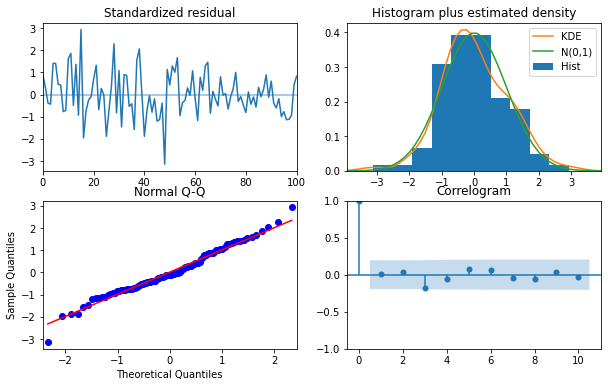

In [44]:
stepwise_model.plot_diagnostics();

In [22]:
print('auto-fit order: :', stepwise_model.order)
print('auto-fit seasonal_order: :', stepwise_model.seasonal_order)

auto-fit order: : (0, 0, 1)
auto-fit seasonal_order: : (0, 1, 1, 12)


In [45]:
testing_predict = future_preds_df(stepwise_model,datasetLogDiffShifting_train,30)
testing_predict

,0
1958-07-01,0.095754
1958-08-01,-0.009342
1958-09-01,-0.132159
1958-10-01,-0.142270
1958-11-01,-0.129349
1958-12-01,0.116465
1959-01-01,0.021133
1959-02-01,-0.048456
1959-03-01,0.145197
1959-04-01,-0.027523


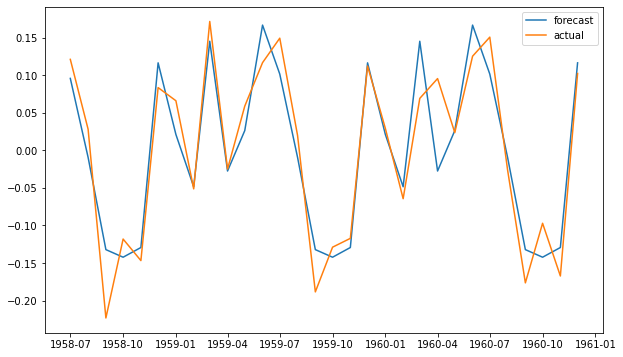

In [52]:
datasetLogDiffShifting_test
plt.plot(testing_predict, label = 'forecast')
plt.legend()
plt.plot(datasetLogDiffShifting_test,label ='actual')
plt.legend()
plt.show()

In [62]:
auto_mape = mape(datasetLogDiffShifting_test.Passengers,testing_predict[0].values)
auto_mape

148.12828508368747

array([ 0.09575374, -0.00934226, -0.13215852, -0.14227003, -0.12934893,
        0.11646491,  0.02113255, -0.04845598,  0.14519713, -0.02752313,
        0.02627516,  0.16671096,  0.1015224 , -0.00934226, -0.13215852,
       -0.14227003, -0.12934893,  0.11646491,  0.02113255, -0.04845598,
        0.14519713, -0.02752313,  0.02627516,  0.16671096,  0.1015224 ,
       -0.00934226, -0.13215852, -0.14227003, -0.12934893,  0.11646491])

In [63]:
dataset.describe()

,#Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000
